In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox

In [3]:
def getStoreDFWithLoad(storeId: int, departementId: int, testSize: int=0):
    df = pd.read_csv("data/train.csv")
    store = df[(df["Store"] == storeId) & (df["Dept"] == departementId)]
    if (len(store) < 1):
        return None, None
    store['Date'] = pd.to_datetime(store['Date'], format='%Y-%m-%d')
    if (testSize > 0):
        store_train = store[:-testSize]
        store_test = store[-testSize:]
        return store_train, store_test
    return store, None

def getStoreDF(storeId: int, departementId: int, dataFrame, testSize: int=0):
    store = dataFrame[(dataFrame["Store"] == storeId) & (dataFrame["Dept"] == departementId)]
    if (len(store) < 1):
        return None, None
    store['Date'] = pd.to_datetime(store['Date'], format='%Y-%m-%d')
    if (testSize > 0):
        store_train = store[:-testSize]
        store_test = store[-testSize:]
        return store_train, store_test
    return store, None

def getStationaryValue(store, maxNumberOfRepetitions: int=3, pValue:int=0.05):
    series = store["Weekly_Sales"]
    numberOfDifferentiation = 0
    while(numberOfDifferentiation < maxNumberOfRepetitions and adfuller(series)[1] > pValue):
        series = series.diff().dropna()
        numberOfDifferentiation += 1
    return series, numberOfDifferentiation

def plot_ACF_PACF(stationary, lags=30):
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    plot_acf(stationary, lags=lags, ax=ax[0], title='ACF of Differenced Data')
    plot_pacf(stationary, lags=lags, ax=ax[1], title='PACF of Differenced Data')
    plt.show()

def getACF(stationary, pValue=0.05, confidence=0.25, nlags=20):
    acfValues, acfConfidence = acf(stationary, nlags=nlags, alpha=pValue, fft=False)
    return [i for i, acfValue in enumerate(acfValues) if abs(acfValue) > confidence]

def getPACF(stationary, pValue=0.05, confidence=0.25, nlags=20):
    pacfValues, pacfConfidence = pacf(stationary, nlags=nlags, alpha=pValue)
    return [i for i, pacfValues in enumerate(pacfValues) if abs(pacfValues) > confidence]

def getArimaFit(stationary, ar, nDiff, ma):
    model = ARIMA(stationary, order=(ar,nDiff, ma))
    return model.fit()

def getForecast(model, diffs, lastDate, predictionLength):
    newDates = pd.date_range(start=lastDate + pd.Timedelta(weeks=1), periods=predictionLength, freq="W-FRI")
    forecast = pd.DataFrame({"Date": newDates, "Weekly_Sales": model.forecast(steps=predictionLength)})
    for diff in diffs:
        forecast.iloc[0, 1] = diff.iloc[-1] + forecast.iloc[0, 1]
        for i in range(1, predictionLength):
            forecast.iloc[i, 1] = forecast.iloc[i, 1] + forecast.iloc[i -1, 1]
    return forecast


def plotForeCast(store_train, store_test, forecast):
    plt.figure(figsize=(12, 6))
    plt.plot(store_train['Date'], store_train['Weekly_Sales'], label='Historical Sales')
    plt.plot(forecast["Date"], forecast["Weekly_Sales"], label='Forecasted Sales', color='red')
    plt.plot(store_test["Date"], store_test["Weekly_Sales"], label='Actual Sales', color='green')
    plt.title('Sales Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

def isNormalDistributedShapiro(residuals, pValueThreshold = 0.05):
    shapiro_test_statistic, p_value = shapiro(residuals)
    return p_value > pValueThreshold

def noAutoCorrelationInResidual(residuals, lag, pValueThreshold=0.05):
    ljung_box_test = acorr_ljungbox(residuals, lags=[lag], return_df=True)
    return ljung_box_test.iloc[0,1] > pValueThreshold
    

In [39]:
store_train, store_test = getStoreDFWithLoad(1,1,5)

C:\Users\adijo\AppData\Local\Temp\ipykernel_30016\2267027003.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store['Date'] = pd.to_datetime(store['Date'], format='%Y-%m-%d')


In [40]:
diff, n = getStationaryValue(store_train)

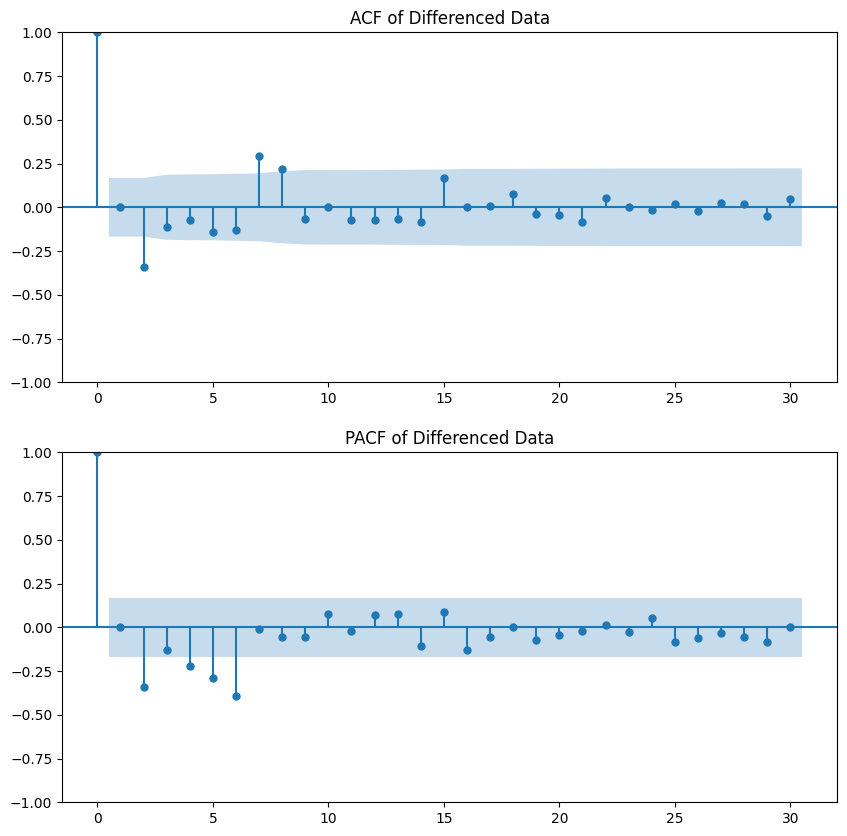

In [41]:
plot_ACF_PACF(diff, lags=30)

In [48]:
ma = max(getACF(diff, nlags=55, confidence=0.3))

In [49]:
ar = max(getPACF(diff, nlags=55, confidence=0.25))

In [50]:
print(ma)
print(ar)

2
55


In [51]:
model = getArimaFit(diff, ar=ar, nDiff=n, ma=ma)

c:\Users\adijo\.conda\envs\timeSeriesAnalysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adijo\.conda\envs\timeSeriesAnalysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adijo\.conda\envs\timeSeriesAnalysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\adijo\.conda\envs\timeSeriesAnalysis\Lib\site-packages\statsmodels\tsa\state

In [52]:
PreviousWeekly = store_train["Weekly_Sales"]
lastDate = store_train["Date"].max()
forecast = getForecast(model, (PreviousWeekly,), lastDate, 52)


c:\Users\adijo\.conda\envs\timeSeriesAnalysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\adijo\.conda\envs\timeSeriesAnalysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


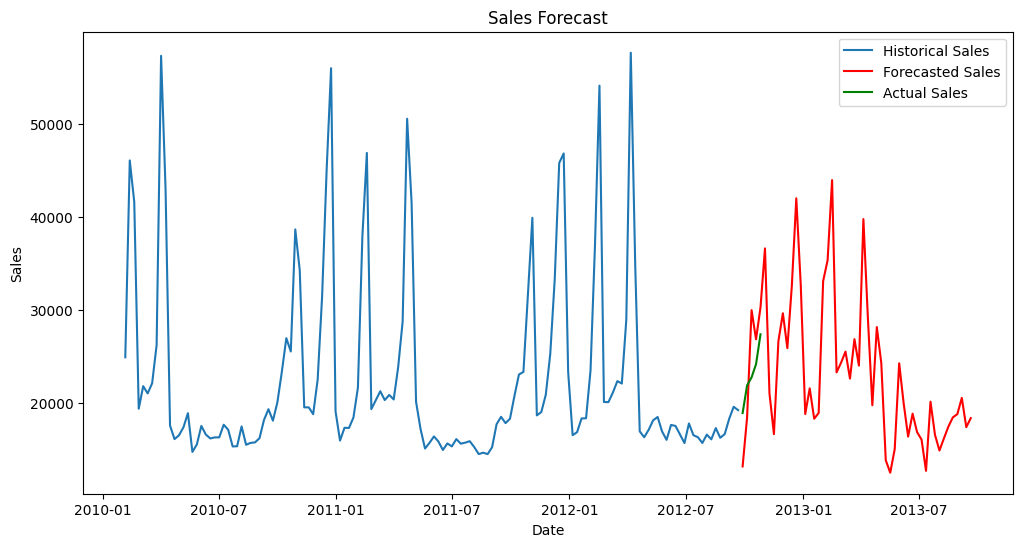

In [53]:
plotForeCast(store_train, store_test, forecast)

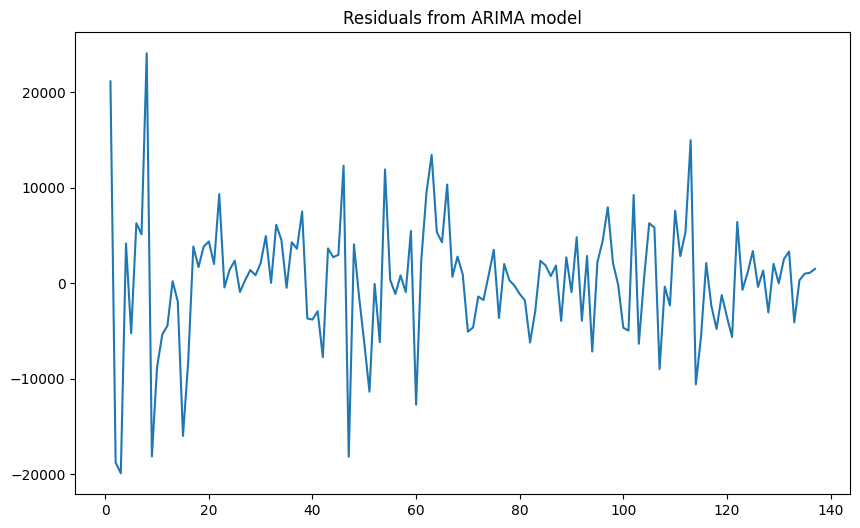

In [54]:
# Extract residuals
residuals = model.resid

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title("Residuals from ARIMA model")
plt.show()

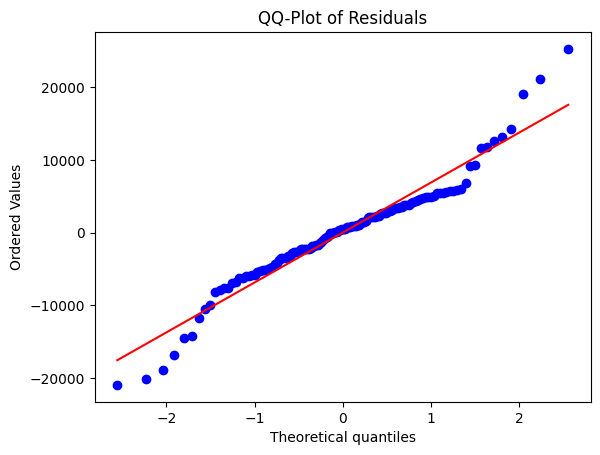

In [44]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# QQ-plot of residuals
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ-Plot of Residuals")
plt.show()

In [45]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test on residuals
shapiro_test_statistic, p_value = shapiro(residuals)

print(f"Shapiro-Wilk Test Statistic: {shapiro_test_statistic}")
print(f"P-value: {p_value}")

# Interpretation
if p_value > 0.05:
    print("Residuals are normally distributed (fail to reject H0).")
else:
    print("Residuals are not normally distributed (reject H0).")


Shapiro-Wilk Test Statistic: 0.948707457121665
P-value: 9.0284625832874e-05
Residuals are not normally distributed (reject H0).


In [46]:
print(isNormalDistributedShapiro(residuals))
print(noAutoCorrelationInResidual(residuals, ar))

False
True


In [47]:
ljung_box_test = acorr_ljungbox(residuals, lags=[ar], return_df=True)

In [48]:
ljung_box_test.iloc[0,1]

np.float64(0.999999999618646)

In [49]:
ljung_box_test

,lb_stat,lb_pvalue
60,14.836724,1.0


In [4]:
values = pd.read_csv("results/arima10Statistics.csv")

In [5]:
values.head()

,storeId,departmentId,ma,ar,nDiff,shapiroStat,ShapiroValue,ljungStat,ljungValue
0,1,1,2,6,1,0.932471,2.631740e-06,0.784355,0.992487
1,1,3,3,1,0,0.700399,1.023641e-15,0.023172,0.879010
2,1,4,4,4,0,0.958968,2.880546e-04,0.048840,0.999707
3,1,5,4,1,0,0.732854,8.006294e-15,0.000119,0.991306
4,1,7,2,5,0,0.619968,1.163197e-17,0.448513,0.993887


In [6]:
for number, row in values.iterrows():
    print(row["storeId"])
    print(row["departmentId"])

1.0
1.0
1.0
3.0
1.0
4.0
1.0
5.0
1.0
7.0
1.0
8.0
1.0
9.0
1.0
10.0
1.0
11.0
1.0
12.0
1.0
13.0
1.0
14.0
1.0
16.0
1.0
17.0
1.0
18.0
1.0
19.0
1.0
20.0
1.0
21.0
1.0
22.0
1.0
23.0
1.0
24.0
1.0
25.0
1.0
26.0
1.0
27.0
1.0
29.0
1.0
30.0
1.0
31.0
1.0
32.0
1.0
33.0
1.0
34.0
1.0
35.0
1.0
36.0
1.0
37.0
1.0
38.0
1.0
40.0
1.0
41.0
1.0
42.0
1.0
44.0
1.0
46.0
1.0
48.0
1.0
49.0
1.0
52.0
1.0
54.0
1.0
55.0
1.0
56.0
1.0
59.0
1.0
60.0
1.0
67.0
1.0
71.0
1.0
74.0
1.0
79.0
1.0
80.0
1.0
81.0
1.0
82.0
1.0
83.0
1.0
85.0
1.0
87.0
1.0
90.0
1.0
91.0
1.0
92.0
1.0
93.0
1.0
94.0
1.0
95.0
1.0
96.0
1.0
97.0
1.0
98.0
2.0
1.0
2.0
3.0
2.0
4.0
2.0
5.0
2.0
6.0
2.0
7.0
2.0
8.0
2.0
9.0
2.0
10.0
2.0
11.0
2.0
12.0
2.0
13.0
2.0
14.0
2.0
16.0
2.0
17.0
2.0
18.0
2.0
19.0
2.0
20.0
2.0
21.0
2.0
22.0
2.0
23.0
2.0
24.0
2.0
25.0
2.0
26.0
2.0
27.0
2.0
28.0
2.0
29.0
2.0
30.0
2.0
31.0
2.0
32.0
2.0
33.0
2.0
34.0
2.0
35.0
2.0
36.0
2.0
37.0
2.0
38.0
2.0
40.0
2.0
41.0
2.0
44.0
2.0
46.0
2.0
49.0
2.0
52.0
2.0
54.0
2.0
55.0
2.0
56.0
2.0
58.0
2.0
59.